# Demonstração do algoritmo PROST

Esse notebook contém uma demonstração do algoritmo PROST para *tracking* de objetos. É possível controlar qual base de dados deve ser utilizada.

## Imports

A próxima célula realiza os imports necessários para execução do algoritmo.

In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from prost import FLOW, NCC, Dataset, MatchRect
from prost.core import compare_match

## Funções Utilitárias

Algumas funções utilitárias para simplificar a construção do Notebook.

In [2]:
def show(img: np.ndarray, gt_rect: MatchRect = None, rect: MatchRect = None):
    _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    def maybe_draw(r: MatchRect, c='g'):
        if r is not None:
            x, y, w, h = r.as_bounding_rect()
            ax.add_patch(patches.Rectangle((x, y), w, h,
                                           linewidth=1,
                                           edgecolor=c,
                                           facecolor='none'))

    maybe_draw(gt_rect)
    maybe_draw(rect, 'b')


def get_template(img: np.ndarray, gt_rect: MatchRect):
    x, y, w, h = gt_rect.as_bounding_rect()
    return img[y:y+h, x:x+w]

# Carregando Dataset

Todas as sequências de imagem utilizadas foram extraídas de https://web.archive.org/web/20140418040427/http://vision.ucsd.edu/~bbabenko/project_miltrack.shtml. Ao instanciar o dataset, os arquivos são baixados automaticamente (~250MB).

Todos os datasets considerados possuem *Ground Truth* para frames múltiplos de *5* (i.e., frame 0, 5, 10, 15, etc). Os demais frames não possuem GT. Nas imagens, o verde indica o GT e o azul a região predita pelo algoritmo.

In [3]:
ds = Dataset('girl')
idx = ds.start_idx()
n_after = 10

while idx % 5 != 0:
    idx += 1

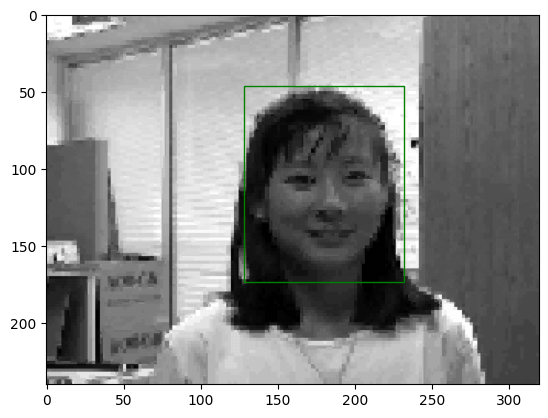

In [4]:
show(*ds.get(idx))

# Componente 1: NCC

Um dos componentes do PROST é o NCC (Normalized Cross Correlation), uma técnica de *Template Matching* que recebe um *template* como entrada e é capaz de fazer o *match* em imagens arbitrárias.

In [5]:
ncc = NCC(get_template(*ds.get(idx)))

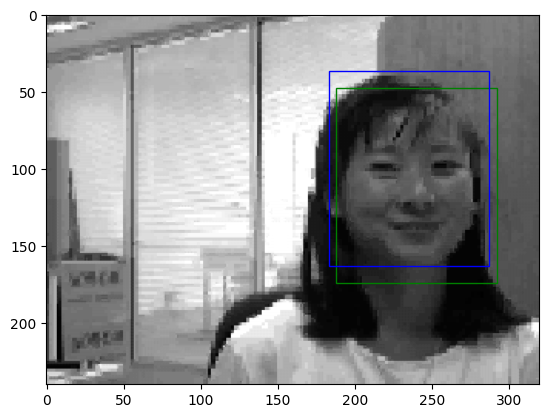

In [6]:
show(*compare_match(ds, ncc, idx + n_after))

# Componente 2: FLOW

O 2º componente do PROST é um *tracker* baseado no Dense Optical Flow, recebendo como entrada o ROI e a imagem atual. O intuito é utilizar um procedimento Mean Shift com os *flow vectors* no espaço 2D para atualizar o ROI a cada nova imagem recebida.

In [7]:
flow = FLOW(*ds.get(idx))

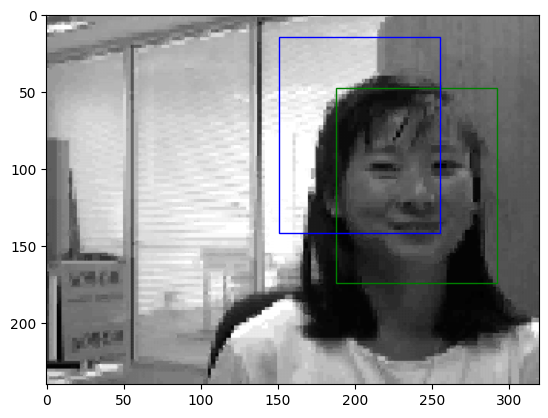

In [8]:
t = idx + n_after
for i in range(idx + 1, t):
    compare_match(ds, flow, i)
show(*compare_match(ds, flow, t))

# Componente 3: Online RF

O último componente do PROST é um *online cascading classifier* baseado no *Online Random Forest*. O treinamento é realizado com o *frame* atual e o *bounding rect* do NCC.